# Auto_scout project Balint - Part 1: cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the data
df = pd.read_json(r'C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind-assignments\Auto_scout\data\scout_car.json', lines=True) # lines=True reads the file as lines of JSON (one JSON object per line)

df.shape

(15919, 54)

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            15919 non-null  object 
 1   make_model                     15919 non-null  object 
 2   short_description              15873 non-null  object 
 3   body_type                      15859 non-null  object 
 4   price                          15919 non-null  int64  
 5   vat                            11406 non-null  object 
 6   km                             15919 non-null  object 
 7   registration                   15919 non-null  object 
 8   prev_owner                     9091 non-null   object 
 9   kW                             0 non-null      float64
 10  hp                             15919 non-null  object 
 11  Type                           15917 non-null  object 
 12  Previous Owners                9279 non-null  

In [4]:
df.describe()

,price,kW
count,15919.000000,0.0
mean,18019.896727,NaN
std,7386.169409,NaN
min,13.000000,NaN
25%,12850.000000,NaN
50%,16900.000000,NaN
75%,21900.000000,NaN
max,74600.000000,NaN


## Columns to drop straight away/that don't contain useful information for a predictive model

In [5]:
useless_cols = ['url','short_description','description'] # short description could potentially be useful if we can extract general information from it, looks too complex to be useful
df = df.drop(useless_cols, axis =1)

## Drop columns containing >90% missing values

In [6]:
# Find proportion of missing values for each column
percent_missing = df.isna().sum()/len(df)*100

# Select columns that have >90% missing values, drop these from the data
high_missing = percent_missing[percent_missing >90].index
df = df.drop(high_missing, axis = 1)
df.shape

(15919, 44)

In [7]:
df.isna().sum()/len(df)*100


make_model                    0.000000
body_type                     0.376908
price                         0.000000
vat                          28.349771
km                            0.000000
registration                  0.000000
prev_owner                   42.892141
hp                            0.000000
Type                          0.012564
Previous Owners              41.711163
Next Inspection              77.793831
Inspection new               75.299956
Warranty                     34.047365
Full Service                 48.395000
Non-smoking Vehicle          54.915510
null                          0.000000
Make                          0.000000
Model                         0.000000
Offer Number                 19.944720
First Registration           10.032037
Body Color                    3.750236
Paint Type                   36.258559
Body Color Original          23.613292
Upholstery                   23.368302
Body                          0.376908
Nr. of Doors             

## Tidy up column names
- Make them all lower case
- join words using underscore
- clean up col name strings (remove leaading and trailing '\n'))

In [8]:
# Clean up column names
df.columns = df.columns.str.strip().str.lower().str.replace(r'\n','').str.replace('&','_').str.replace(' ','').str.replace('.','')
df.columns

Index(['make_model', 'body_type', 'price', 'vat', 'km', 'registration',
       'prev_owner', 'hp', 'type', 'previousowners', 'nextinspection',
       'inspectionnew', 'warranty', 'fullservice', 'non-smokingvehicle',
       'null', 'make', 'model', 'offernumber', 'firstregistration',
       'bodycolor', 'painttype', 'bodycolororiginal', 'upholstery', 'body',
       'nrofdoors', 'nrofseats', 'modelcode', 'gearingtype', 'displacement',
       'cylinders', 'weight', 'drivechain', 'fuel', 'consumption',
       'co2emission', 'emissionclass', 'comfort_convenience',
       'entertainment_media', 'extras', 'safety_security', 'emissionlabel',
       'gears', 'countryversion'],
      dtype='object')

## Compare 'make_model' with 'make' and 'model' columns

In [9]:
dfmm = df[['make_model', 'make', 'model']]
dfmm.sample(10)

# Should I keep 'make' and 'model' as separate features or just 'make_model'? Want to avoid redundancy/multicolinearity in my training dataset.
print(dfmm.make_model.value_counts(dropna=False)) 

# Final decision: keep 'make_model' and drop 'make' and 'model' - simplifies the feauture set more than onehotencoding both 'make' and 'model'
df = df.drop(['make','model'], axis = 1)


make_model
Audi A3           3097
Audi A1           2614
Opel Insignia     2598
Opel Astra        2526
Opel Corsa        2219
Renault Clio      1839
Renault Espace     991
Renault Duster      34
Audi A2              1
Name: count, dtype: int64


## Compare and clean/combine prev_owner and previousowners

In [10]:
df[['prev_owner', 'previousowners']].sample(10)
print(df.prev_owner.value_counts(dropna = False))
print(df.previousowners.value_counts(dropna= False))

prev_owner
1 previous owner     8294
None                 6828
2 previous owners     778
3 previous owners      17
4 previous owners       2
Name: count, dtype: int64
previousowners
\n1\n                                                                                        8101
NaN                                                                                          6640
\n2\n                                                                                         766
\n0\n                                                                                         163
\n3\n                                                                                          17
                                                                                             ... 
[\n1\n, \n85 g CO2/km (comb)\n]                                                                 1
[\n1\n, \n, 5.9 l/100 km (comb), \n, 7.6 l/100 km (city), \n, 5.1 l/100 km (country), \n]       1
[\n1\n, \n188 g CO2/km (comb)\n]  

In [11]:
# clean previousowners column 
df['previousowners_cleaned'] = df['previousowners'].str.replace('\n', '')



In [12]:
# clean prev_owner column: remove strings after number, and convert 'None' to np.nan
def clean_prev_owner(value):
    if isinstance(value, str):
        return value.split()[0] # value.split() splits the string into ['1', 'previous', 'owners'], then select first element 
    if value == 'None' or pd.isna(value):
        return np.nan
    return value

df['prev_owner_cleaned'] = df['prev_owner'].apply(clean_prev_owner)
df['prev_owner_cleaned'].value_counts(dropna= False)

prev_owner_cleaned
1      8294
NaN    6828
2       778
3        17
4         2
Name: count, dtype: int64

In [13]:
# Check the NaN discrepancy across the two columns
discrep = df[df['prev_owner_cleaned'] != df['previousowners_cleaned']]
discrep[['prev_owner_cleaned','previousowners_cleaned']].dropna()
# All discrepencies involve an NaN in one of the columns

,prev_owner_cleaned,previousowners_cleaned


In [14]:
# Have a look at the NaN discrepencies
filtered_df = df[(df['prev_owner_cleaned'].isna() & df['previousowners_cleaned'].notna()) | (df['prev_owner_cleaned'].notna() & df['previousowners_cleaned'].isna())]
filtered_df[['prev_owner_cleaned','previousowners_cleaned']] 

,prev_owner_cleaned,previousowners_cleaned
47,NaN,0
418,NaN,0
586,NaN,0
648,NaN,0
734,NaN,0
...,...,...
15794,1,NaN
15853,NaN,0
15860,NaN,0
15915,1,NaN


In [15]:
# Some values are NaN in one, and value in the other, and vice versa. Merge so that we keep the value and discard the NaN these instances by using combine_first
# Now merge the two columns together
df['previous_owners_cleaned'] = df['prev_owner_cleaned'].combine_first(df['previousowners_cleaned'])
df['previous_owners_cleaned'].value_counts(dropna = False)


previous_owners_cleaned
1      8294
NaN    6665
2       778
0       163
3        17
4         2
Name: count, dtype: int64

In [16]:
# Drop columns not needed anymore
df = df.drop(['prev_owner_cleaned','previousowners_cleaned','prev_owner', 'previousowners'], axis = 1)

## 'Null' column

In [17]:
print(df['null'].value_counts(dropna = False))
# Drop the 'null' column
df = df.drop('null', axis = 1)

null
[]    15919
Name: count, dtype: int64


In [18]:
df.columns

Index(['make_model', 'body_type', 'price', 'vat', 'km', 'registration', 'hp',
       'type', 'nextinspection', 'inspectionnew', 'warranty', 'fullservice',
       'non-smokingvehicle', 'offernumber', 'firstregistration', 'bodycolor',
       'painttype', 'bodycolororiginal', 'upholstery', 'body', 'nrofdoors',
       'nrofseats', 'modelcode', 'gearingtype', 'displacement', 'cylinders',
       'weight', 'drivechain', 'fuel', 'consumption', 'co2emission',
       'emissionclass', 'comfort_convenience', 'entertainment_media', 'extras',
       'safety_security', 'emissionlabel', 'gears', 'countryversion',
       'previous_owners_cleaned'],
      dtype='object')

## Compare 'co2emission', 'emissionclass', 'emissionlabel' columns

In [19]:
df[['co2emission', 'emissionclass', 'emissionlabel']]
df['emissionlabel'].value_counts(dropna = False)

emissionlabel
NaN                     11934
[\n4 (Green)\n]          3553
[\n1 (No sticker)\n]      381
[[], [], []]               40
[\n5 (Blue)\n]              8
[\n3 (Yellow)\n]            2
[\n2 (Red)\n]               1
Name: count, dtype: int64

## Co2 emission

In [20]:
def cleann_column(series):
    # Convert the series to string type
    series = series.astype(str)
    # Strip unwanted characters and replace newlines
    return series.str.strip('[]\\n').str.replace('\\n', '', regex=False)

# Apply the cleaning function to each column
df['co2emission'] = cleann_column(df['co2emission'])
df['emissionclass'] = cleann_column(df['emissionclass'])
df['emissionlabel'] = cleann_column(df['emissionlabel'])


In [21]:
import re
# Define a function to clean the emission values
def extract_int(value):
    if isinstance(value, str):
        # Remove any unwanted characters and extract the numeric part
        value = re.sub(r'[^\d]', '', value)  # Remove everything except digits
        return int(value) if value else np.nan  # Convert to int or return NaN if empty
    return np.nan

# Apply the cleaning function to the column
df['co2emission_cleaned_gCO2/km'] = df['co2emission'].apply(extract_int)
df['co2emission_cleaned_gCO2/km'].value_counts(dropna=False)

co2emission_cleaned_gCO2/km
NaN       2436
1202.0     740
992.0      545
972.0      537
1042.0     501
          ... 
1802.0       1
1712.0       1
1832.0       1
12.0         1
1932.0       1
Name: count, Length: 123, dtype: int64

## emissionlabel column

In [22]:
df['emissionlabel'].value_counts()
df['emissionlabel'] =df['emissionlabel'].str.strip()
# define values to make np.nan
values_to_nan = ['a', ', [],']

# Replace these values with np.nan
df['emissionlabel'] = df['emissionlabel'].replace(values_to_nan, np.nan) # not sure why this returns string nan, need NaN! 
df['emissionlabel'] = df['emissionlabel'].replace('nan', np.nan)
df['emissionlabel'].value_counts(dropna = False)


emissionlabel
NaN                 11974
'4 (Green)'          3553
'1 (No sticker)'      381
'5 (Blue)'              8
'3 (Yellow)'            2
'2 (Red)'               1
Name: count, dtype: int64

In [23]:
import re
# Define a function to extract the color (I think this is more meaningful than a category number?)
def extract_color(label):
    match = re.search(r'\(([^)]+)\)', label)
    return match.group(1) if match else np.nan

# convert column to string
df['emissionlabel'] = df['emissionlabel'].astype(str)
# Apply the function to the column
df['emissionlabel_cleaned'] = df['emissionlabel'].apply(extract_color)

# Check the cleaned values
print(df['emissionlabel_cleaned'].value_counts(dropna=False))

# Should we convert 'No sticker' to NaN? Depends if 'no sticker' is the same as 'unknown sticker' (assuming NaN is 'unknown sticker')

emissionlabel_cleaned
NaN           11974
Green          3553
No sticker      381
Blue              8
Yellow            2
Red               1
Name: count, dtype: int64


## emissionclass column


In [24]:
# Remove Euro and -TEMP from beginning and end of values
df['emissionclass'] =df['emissionclass'].str.replace('Euro','').str.replace('-TEMP', '')
# strip leading/trailing whitespace
df['emissionclass'] =df['emissionclass'].str.strip()
# Convert 'a' and ', []' to NaN
values_to_nan = ['a', ', [],']
# Replace these values with np.nan
df['emissionclass_cleaned'] = df['emissionclass'].replace(values_to_nan, np.nan) # not sure why this returns string nan, need NaN! 
df['emissionclass_cleaned'].value_counts(dropna = False)


emissionclass_cleaned
' 6'     10139
NaN       3628
' 6d'     1907
' 6c'      127
' 5'        78
' 4'        40
Name: count, dtype: int64

In [25]:
# Drop emissionclass, emissionlabel, and co2emission columns
df = df.drop(['emissionclass', 'emissionlabel', 'co2emission'], axis = 1)
df.columns

Index(['make_model', 'body_type', 'price', 'vat', 'km', 'registration', 'hp',
       'type', 'nextinspection', 'inspectionnew', 'warranty', 'fullservice',
       'non-smokingvehicle', 'offernumber', 'firstregistration', 'bodycolor',
       'painttype', 'bodycolororiginal', 'upholstery', 'body', 'nrofdoors',
       'nrofseats', 'modelcode', 'gearingtype', 'displacement', 'cylinders',
       'weight', 'drivechain', 'fuel', 'consumption', 'comfort_convenience',
       'entertainment_media', 'extras', 'safety_security', 'gears',
       'countryversion', 'previous_owners_cleaned',
       'co2emission_cleaned_gCO2/km', 'emissionlabel_cleaned',
       'emissionclass_cleaned'],
      dtype='object')

## Compare 'body_type','body' columns

In [26]:
df[['body_type', 'body']].sample(20)

,body_type,body
6163,Station wagon,"[\n, Station wagon, \n]"
4465,Sedans,"[\n, Sedans, \n]"
2939,Station wagon,"[\n, Station wagon, \n]"
9301,Compact,"[\n, Compact, \n]"
4087,Sedans,"[\n, Sedans, \n]"
11950,Station wagon,"[\n, Station wagon, \n]"
8259,Sedans,"[\n, Sedans, \n]"
11092,Sedans,"[\n, Sedans, \n]"
4850,Sedans,"[\n, Sedans, \n]"
11542,Station wagon,"[\n, Station wagon, \n]"


In [27]:
# Create a function similar to cleann_column that also removes ','
def clean_column(series):
    series = series.astype(str)
    # Strip unwanted characters and replace newlines
    return series.str.split(',').str[1].str.strip(" \n[]'")

In [28]:
# body_type and 'body' look very similar, clean 'body' and then check
df['body_cleaned'] = clean_column(df['body'])
df['body_cleaned'].value_counts(dropna =False)

body_cleaned
Sedans           7903
Station wagon    3553
Compact          3153
Van               783
Other             290
Transporter        88
NaN                60
Off-Road           56
Coupe              25
Convertible         8
Name: count, dtype: int64

In [29]:
# Check body_type
df['body_type'].value_counts(dropna = False)
# body_type identical to body_cleaned, so keep body_cleaned
df = df.drop('body_type', axis = 1)

## Compare'bodycolor', 'bodycolororiginal' columns

In [30]:
# Clean the bodycolor feature
df['bodycolor_cleaned'] = clean_column(df['bodycolor'])
df['bodycolor_cleaned'].value_counts(dropna=False)
df = df.drop('bodycolor', axis = 1)

In [31]:
# Drop the bodycolororiginal column - lots of NaNs and useful information all in 'bodycolor_cleaned' variable now
df = df.drop('bodycolororiginal', axis = 1)

In [32]:
df.columns

Index(['make_model', 'price', 'vat', 'km', 'registration', 'hp', 'type',
       'nextinspection', 'inspectionnew', 'warranty', 'fullservice',
       'non-smokingvehicle', 'offernumber', 'firstregistration', 'painttype',
       'upholstery', 'body', 'nrofdoors', 'nrofseats', 'modelcode',
       'gearingtype', 'displacement', 'cylinders', 'weight', 'drivechain',
       'fuel', 'consumption', 'comfort_convenience', 'entertainment_media',
       'extras', 'safety_security', 'gears', 'countryversion',
       'previous_owners_cleaned', 'co2emission_cleaned_gCO2/km',
       'emissionlabel_cleaned', 'emissionclass_cleaned', 'body_cleaned',
       'bodycolor_cleaned'],
      dtype='object')

** Look at price (target variable?) and vat columns


<Axes: ylabel='price'>

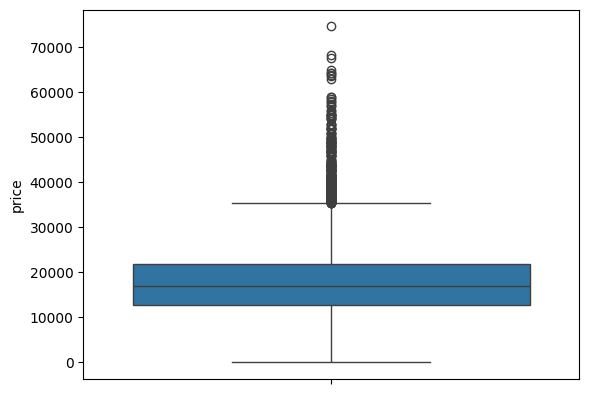

In [33]:
sns.boxplot(df['price'])

In [34]:
df['vat'].value_counts(dropna= False)

vat
VAT deductible      10980
None                 4513
Price negotiable      426
Name: count, dtype: int64

## km column

In [35]:
df['km'].value_counts(dropna= False)

km
10 km        1045
- km         1024
1 km          367
5 km          170
50 km         148
             ... 
10,227 km       1
10,803 km       1
14,328 km       1
22,987 km       1
15,042 km       1
Name: count, Length: 6690, dtype: int64

In [36]:
# drop 'km' and convert to integer
df['km'] = df['km'].str.replace(' km','').str.replace(',','').str.replace('-','')
df['km_cleaned'] = pd.to_numeric(df['km']).astype('Int64')
df['km_cleaned'].sample(10)

df = df.drop('km', axis = 1)


In [37]:
## VAT column

In [38]:
df['vat'].value_counts(dropna = False)

vat
VAT deductible      10980
None                 4513
Price negotiable      426
Name: count, dtype: int64

In [39]:
# Convert 'None' to np.NaN
df['vat_cleaned'] = df['vat'].replace([None, 'None', ' None', ' None '], np.nan)
df = df.drop('vat', axis = 1)

## Registration column

In [40]:
df['registration'].value_counts(dropna = False)
# Convert -/- to np.nan
df['registration'] = df['registration'].replace('-/-', np.nan)

In [41]:
# convert feature to datetime data type
df['registration_cleaned'] = pd.to_datetime(df['registration'])
df = df.drop('registration', axis = 1)

C:\Users\BalintStewart\AppData\Local\Temp\ipykernel_22588\382052923.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['registration_cleaned'] = pd.to_datetime(df['registration'])


In [42]:
#compare with firstregistration column
df.firstregistration.value_counts(dropna = False)
df.registration_cleaned

0       2016-01-01
1       2017-03-01
2       2016-02-01
3       2016-08-01
4       2016-05-01
           ...    
15914          NaT
15915   2019-01-01
15916   2019-03-01
15917   2019-06-01
15918   2019-01-01
Name: registration_cleaned, Length: 15919, dtype: datetime64[ns]

In [43]:
# registration_cleaned has more info that firstregistration, just make sure year counts are same across both
df['registration_cleaned'].dt.year.value_counts().sort_index()

registration_cleaned
2016.0    3674
2017.0    3273
2018.0    4522
2019.0    2853
Name: count, dtype: int64

In [44]:
df.drop('firstregistration', axis = 1)

,make_model,price,hp,type,nextinspection,inspectionnew,warranty,fullservice,non-smokingvehicle,offernumber,...,countryversion,previous_owners_cleaned,co2emission_cleaned_gCO2/km,emissionlabel_cleaned,emissionclass_cleaned,body_cleaned,bodycolor_cleaned,km_cleaned,vat_cleaned,registration_cleaned
0,Audi A1,15770,66 kW,"[, Used, , Diesel (Particulate Filter)]","[\n06/2021\n, \n99 g CO2/km (comb)\n]","[\nYes\n, \nEuro 6\n]","[\n, \n, \n4 (Green)\n]","[\n, \n]","[\n, \n]",[\nLR-062483\n],...,NaN,2,992.0,NaN,' 6',Sedans,Black,56013,VAT deductible,2016-01-01
1,Audi A1,14500,141 kW,"[, Used, , Gasoline]",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1292.0,Green,' 6',Sedans,Red,80000,Price negotiable,2017-03-01
2,Audi A1,14640,85 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,NaN,"[\n, \n, \n99 g CO2/km (comb)\n]",NaN,NaN,[\nAM-95365\n],...,NaN,1,992.0,Green,' 6',Sedans,Black,83450,VAT deductible,2016-02-01
3,Audi A1,14500,66 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,NaN,NaN,"[\n, \n, \n99 g CO2/km (comb)\n]","[\n, \n, \nEuro 6\n]",NaN,...,NaN,1,992.0,NaN,' 6',Sedans,Brown,73000,NaN,2016-08-01
4,Audi A1,16790,66 kW,"[, Used, , Diesel (Particulate Filter)]",NaN,"[\nYes\n, \n109 g CO2/km (comb)\n]","[\n, \n, \nEuro 6\n]","[\n, \n, \n4 (Green)\n]","[\n, \n]",[\nC1626\n],...,[\nGermany\n],1,1092.0,NaN,' 6',Sedans,Black,16200,NaN,2016-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15914,Renault Espace,39950,147 kW,"[, New, , Diesel (Particulate Filter)]",NaN,NaN,\n24 months\n,NaN,NaN,[\n10988301\n],...,NaN,NaN,1392.0,NaN,NaN,Van,Grey,<NA>,VAT deductible,NaT
15915,Renault Espace,39885,165 kW,"[, Used, , Super 95 / Super Plus 98 (Particula...","[\n01/2022\n, \n168 g CO2/km (comb)\n]",NaN,"[\n, \n, \nEuro 6\n]",NaN,"[\n, \n, \n4 (Green)\n]",[\n507370_3223\n],...,[\nGermany\n],1,1682.0,NaN,NaN,Van,Grey,9900,VAT deductible,2019-01-01
15916,Renault Espace,39875,146 kW,"[, Pre-registered, , Diesel]",NaN,"[\nYes\n, \nEuro 6d-TEMP\n]","[\n, \n, \n4 (Green)\n]","[\n, \n]","[\n, \n]",[\nEspace16\n],...,[\nAustria\n],1,1392.0,NaN,' 6d',Van,White,15,VAT deductible,2019-03-01
15917,Renault Espace,39700,147 kW,"[, Pre-registered, , Diesel]",NaN,NaN,\n,NaN,NaN,[\n2691331\n],...,NaN,NaN,1392.0,NaN,' 6',Van,Grey,10,VAT deductible,2019-06-01


# hp column

In [45]:
df.hp.value_counts(dropna = False)

hp
85 kW     2542
66 kW     2122
81 kW     1402
100 kW    1308
110 kW    1112
          ... 
239 kW       1
123 kW       1
4 kW         1
163 kW       1
115 kW       1
Name: count, Length: 81, dtype: int64

In [46]:
#drop kW, add unit to column name and make into Int64 dtype
df['hp_kW_cleaned'] = df['hp'].str.replace('kW', '').str.replace('- ', '')
df['hp_kW_cleaned'] = pd.to_numeric(df['hp_kW_cleaned']).astype('Int64')
# Replace pd.NA with np.nan
df['hp_kW_cleaned'] = df['hp_kW_cleaned'].replace('<NA>', np.nan)
df = df.drop('hp', axis = 1)

In [47]:
df.columns

Index(['make_model', 'price', 'type', 'nextinspection', 'inspectionnew',
       'warranty', 'fullservice', 'non-smokingvehicle', 'offernumber',
       'firstregistration', 'painttype', 'upholstery', 'body', 'nrofdoors',
       'nrofseats', 'modelcode', 'gearingtype', 'displacement', 'cylinders',
       'weight', 'drivechain', 'fuel', 'consumption', 'comfort_convenience',
       'entertainment_media', 'extras', 'safety_security', 'gears',
       'countryversion', 'previous_owners_cleaned',
       'co2emission_cleaned_gCO2/km', 'emissionlabel_cleaned',
       'emissionclass_cleaned', 'body_cleaned', 'bodycolor_cleaned',
       'km_cleaned', 'vat_cleaned', 'registration_cleaned', 'hp_kW_cleaned'],
      dtype='object')

## nextinspection and inspectionnew columns

In [48]:
df['nextinspection'].value_counts()

nextinspection
\n04/2022\n                               62
\n03/2021\n                               38
\n03/2022\n                               36
\n06/2021\n                               34
\n01/2022\n                               32
                                          ..
[\n01/2022\n, \n193 g CO2/km (comb)\n]     1
[\n06/2020\n]                              1
[\n10/2020\n]                              1
[\n01/2019\n, \n153 g CO2/km (comb)\n]     1
[\n04/2021\n, \n153 g CO2/km (comb)\n]     1
Name: count, Length: 1399, dtype: int64

In [49]:
# Extract MM/YYYY pattern
df['nextinspection_cleaned'] = df['nextinspection'].str.extract(r'(\d{2}/\d{4})')
# Convert to datetime
df['nextinspection_cleaned'] = pd.to_datetime(df['nextinspection_cleaned'], format='%m/%Y', errors='coerce')
df.nextinspection_cleaned.value_counts(dropna = False) # Looks like quite a lot of NaTs?
df = df.drop('nextinspection', axis = 1)


In [50]:
df.inspectionnew.value_counts(dropna = False) # doesn't look like this column contains any useful info, all are either NaN or 'Yes', emission info elsewhere
df = df.drop('inspectionnew', axis = 1)

## Type column

In [51]:
df.type.value_counts(dropna = False)
# type column appears to have two pieces of info - whether the car is new or used, and what fuel it uses. Both useful for our model, so split into two columns: 'type' and 'fuel'
# Create new 'type_cleaned' containing element [1] from each row
df['type_cleaned'] = df['type'].apply(lambda x: x[1] if isinstance(x, list) else np.nan)

In [52]:
# Create new column 'fuel' containing element[3] from each list 
df['fuel'] = df['type'].apply(lambda x: x[3] if isinstance(x, list) else np.nan)
df['fuel'].value_counts(dropna = False)

fuel
Diesel (Particulate Filter)                           4315
Super 95                                              3338
Gasoline                                              3175
Diesel                                                2982
Super 95 / Regular/Benzine 91                          424
                                                      ... 
Super 95 / Regular/Benzine 91 (Particulate Filter)       1
Super 95 / Super E10 95 / Super Plus 98                  1
Electric                                                 1
Super 95 / Super Plus 98 / Super Plus E10 98             1
Super Plus 98 / Super 95 / Super Plus E10 98             1
Name: count, Length: 78, dtype: int64

In [53]:
df.fullservice

0                                [\n, \n]
1                                     NaN
2                                     NaN
3        [\n, \n, \n99 g CO2/km (comb)\n]
4                 [\n, \n, \n4 (Green)\n]
                       ...               
15914                                 NaN
15915                                 NaN
15916                            [\n, \n]
15917                                 NaN
15918                                 NaN
Name: fullservice, Length: 15919, dtype: object

In [54]:
df.columns

Index(['make_model', 'price', 'type', 'warranty', 'fullservice',
       'non-smokingvehicle', 'offernumber', 'firstregistration', 'painttype',
       'upholstery', 'body', 'nrofdoors', 'nrofseats', 'modelcode',
       'gearingtype', 'displacement', 'cylinders', 'weight', 'drivechain',
       'fuel', 'consumption', 'comfort_convenience', 'entertainment_media',
       'extras', 'safety_security', 'gears', 'countryversion',
       'previous_owners_cleaned', 'co2emission_cleaned_gCO2/km',
       'emissionlabel_cleaned', 'emissionclass_cleaned', 'body_cleaned',
       'bodycolor_cleaned', 'km_cleaned', 'vat_cleaned',
       'registration_cleaned', 'hp_kW_cleaned', 'nextinspection_cleaned',
       'type_cleaned'],
      dtype='object')